#<font size=8>Packages

In [ ]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from bs4 import BeautifulSoup
import concurrent.futures
import time
import random
from joblib import Parallel, delayed
import re
from tqdm import tqdm
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#<font size=8>Functions

In [ ]:
def read_file(path):
    rawdata = pd.read_csv(path, header=0, delimiter='\t', encoding= 'unicode_escape')
    return rawdata

def preprocess_data(df):
    reviews = []
    for raw in tqdm(df):
        text = BeautifulSoup(raw, 'lxml').get_text()
        only_text = re.sub('[^a-zA-Z]', ' ', text)
        words = word_tokenize(only_text.lower())
        stops = set(stopwords.words('english'))
        non_stopwords = [word for word in words if not word in stops]
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]
        lemma_words = " ".join(lemma_words)
        reviews.append(lemma_words)
    return reviews

def tokenizer_preprocess(list_X_train, list_X_val):
    unique_words = set()
    len_max = 0
    for sent in tqdm(list_X_train):
        unique_words.update(sent)
        if len_max < len(sent):
            len_max = len(sent)
    len(list(unique_words)), len_max

    tokenizer = Tokenizer(num_words=len(list(unique_words)))
    tokenizer.fit_on_texts(list(list_X_train))                   #Use train_data to fit

    X_train = tokenizer.texts_to_sequences(list_X_train)
    X_train = pad_sequences(X_train, maxlen=len_max)

    X_val = tokenizer.texts_to_sequences(list_X_val)
    X_val = pad_sequences(X_val, maxlen=len_max)

    return X_train, X_val

#cross_validation with k fold
def cross_val(model, X_train, y_train, k=10):
  fold = (X_train.shape[0])/k
  accs = []
  for i in range(k):
    thresh_left, thresh_right = round((i)*fold), round((i+1)*fold)

    if thresh_right < X_train.shape[0] and thresh_left < X_train.shape[0]:
      val_x, val_y = X_train[thresh_left:thresh_right], y_train[thresh_left:thresh_right]
      train_x, train_y = np.concatenate([X_train[:thresh_left], X_train[thresh_right:]]), np.concatenate([y_train[:thresh_left], y_train[thresh_right:]])
    else:
      val_x, val_y = X_train[thresh_left:], y_train[thresh_left:]
      train_x, train_y = X_train[:thresh_left], y_train[:thresh_left]

    model.fit(train_x, train_y)
    prediction = model.predict(val_x)
    acc = accuracy_score(prediction, val_y)
    accs.append(acc)

  return np.mean(accs)

def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

#<font size=8>Dataset1
<font size=5>1. Read the data \
<font size=3.5>• dataset1 : x_train data, x_test data, y_train data


In [ ]:
#Put the Test data
train_x_test = pd.read_csv('./gdrive/MyDrive/Dataset1/X_test_1.csv')

#Put the Train x_data and y_data
train_x_train = pd.read_csv('./gdrive/MyDrive/Dataset1/X_train_1.csv')
train_y_train = pd.read_csv('./gdrive/MyDrive/Dataset1/y_train_1.csv')
train_data = pd.concat([train_x_train, train_y_train], axis=1)

<font size=5>2. Data exploration\
<font size=3.5>• overview

In [ ]:
print('------------------------Dataset1----------------------')
train_x_test.describe()
train_data.describe()

------------------------Dataset1----------------------


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
count,958.000000,979.000000,963.000000,984.000000,971.000000,966.000000,978.000000,977.000000,965.000000,972.000000,965.000000,1023.000000
mean,8.373800,0.526118,0.274216,2.510010,0.087151,15.920807,45.801125,0.996776,3.308632,0.663580,10.445009,5.643206
std,1.776455,0.176769,0.193308,1.270972,0.043777,10.158979,33.314198,0.001894,0.153336,0.176466,1.048401,0.816159
min,4.600000,0.120000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990200,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.071000,8.000000,22.000000,0.995650,3.210000,0.550000,9.550000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,37.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.300000,0.640000,0.430000,2.600000,0.091000,22.000000,60.000000,0.997870,3.400000,0.740000,11.100000,6.000000
max,15.600000,1.330000,1.000000,15.400000,0.610000,66.000000,289.000000,1.003690,4.010000,2.000000,14.000000,8.000000


<font size=5>3. Show missing value before preprocessing\
<font size=3.5>• The all features' missing value ratio are less than 6%, so no need to drop.

In [ ]:
train_data.isnull().sum()/len(train_data)

fixed_acidity           0.063539
volatile_acidity        0.043011
citric_acid             0.058651
residual_sugar          0.038123
chlorides               0.050831
free_sulfur_dioxide     0.055718
total_sulfur_dioxide    0.043988
density                 0.044966
pH                      0.056696
sulphates               0.049853
alcohol                 0.056696
class                   0.000000
dtype: float64

<font size=5>4. Drop the duplicated data\
<font size=3.5>• We have to drop the duplicated instances, because they may cause bias.</font>

In [ ]:
train_x_test.drop_duplicates(inplace=True)
train_data.drop_duplicates(inplace=True)
train_data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
count,920.000000,940.000000,924.000000,945.000000,932.000000,927.000000,939.000000,938.000000,926.000000,933.000000,927.000000,984.000000
mean,8.379891,0.526133,0.275335,2.510476,0.087325,15.960626,45.989883,0.996783,3.308078,0.663237,10.436713,5.641260
std,1.781552,0.177828,0.194009,1.273916,0.044552,10.155663,33.381927,0.001903,0.153585,0.172259,1.052571,0.820865
min,4.600000,0.120000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990200,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.071000,8.000000,22.000000,0.995653,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,37.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.300000,0.640000,0.430000,2.600000,0.091000,22.000000,61.000000,0.997880,3.400000,0.740000,11.100000,6.000000
max,15.600000,1.330000,1.000000,15.400000,0.610000,66.000000,289.000000,1.003690,4.010000,2.000000,14.000000,8.000000


<font size=5>5. Show the missing value ratio in each feature\
<font size=3.5>• After drop the duplicated data, the missing value ratio still remain acceptable range

In [ ]:
X_train = train_data.drop("class", axis=1)
y_train = train_data["class"]

X_train.isnull().sum()/X_train.shape[0]

fixed_acidity           0.065041
volatile_acidity        0.044715
citric_acid             0.060976
residual_sugar          0.039634
chlorides               0.052846
free_sulfur_dioxide     0.057927
total_sulfur_dioxide    0.045732
density                 0.046748
pH                      0.058943
sulphates               0.051829
alcohol                 0.057927
dtype: float64

<font size=5>6. As class histgram below, target value are imbalance, 5,6 are dominate.

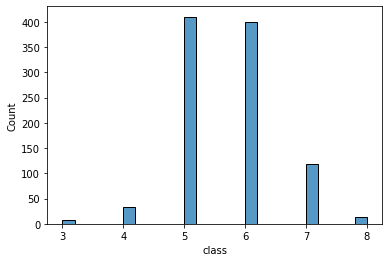

In [ ]:
y_train.value_counts(normalize=True)
sns.histplot(data=y_train)

<font size=5>7. Univariate Analysis\
<font size=3.5>
• The free_sulfur_dioxide, total_sulfur, and sulphates are positive skew.

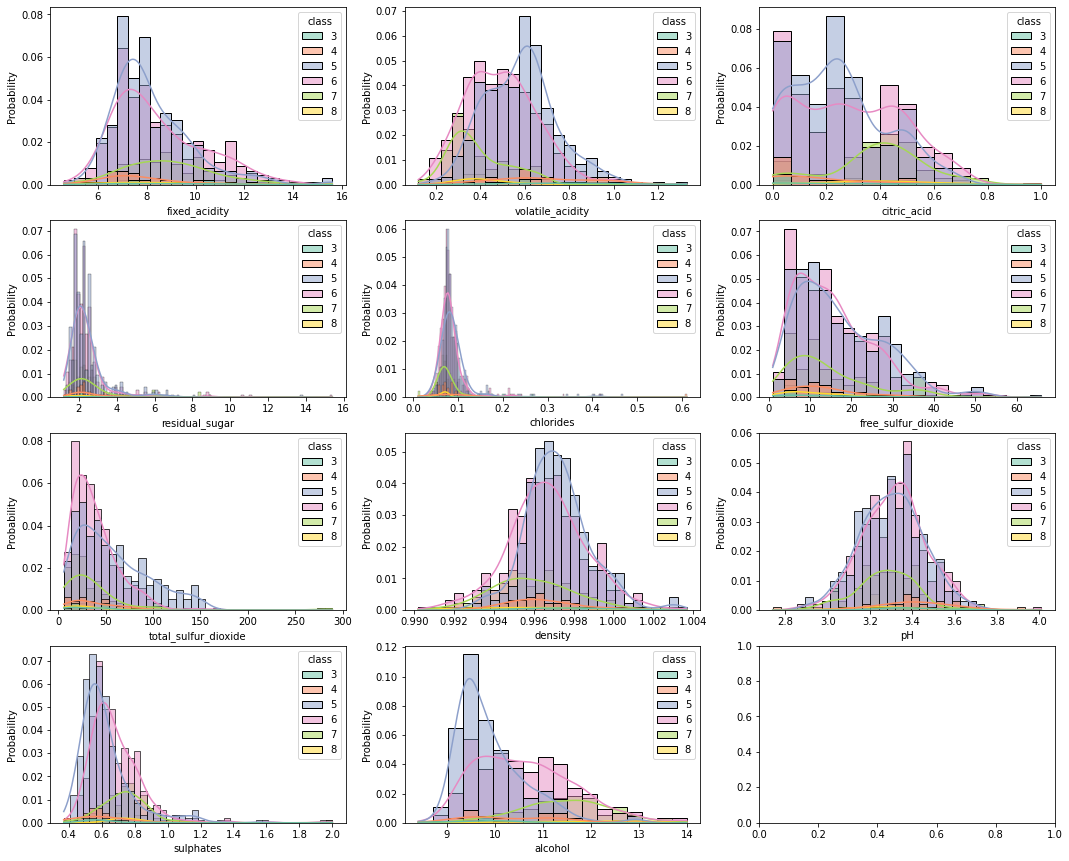

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
for ind, col in zip(axs.flatten()[:-1], X_train.columns):
    sns.histplot(ax=ind, x=col, data=train_data, hue="class", stat="probability", palette="Set2", kde=True)

<font size=5>8. Bivariate Analysis

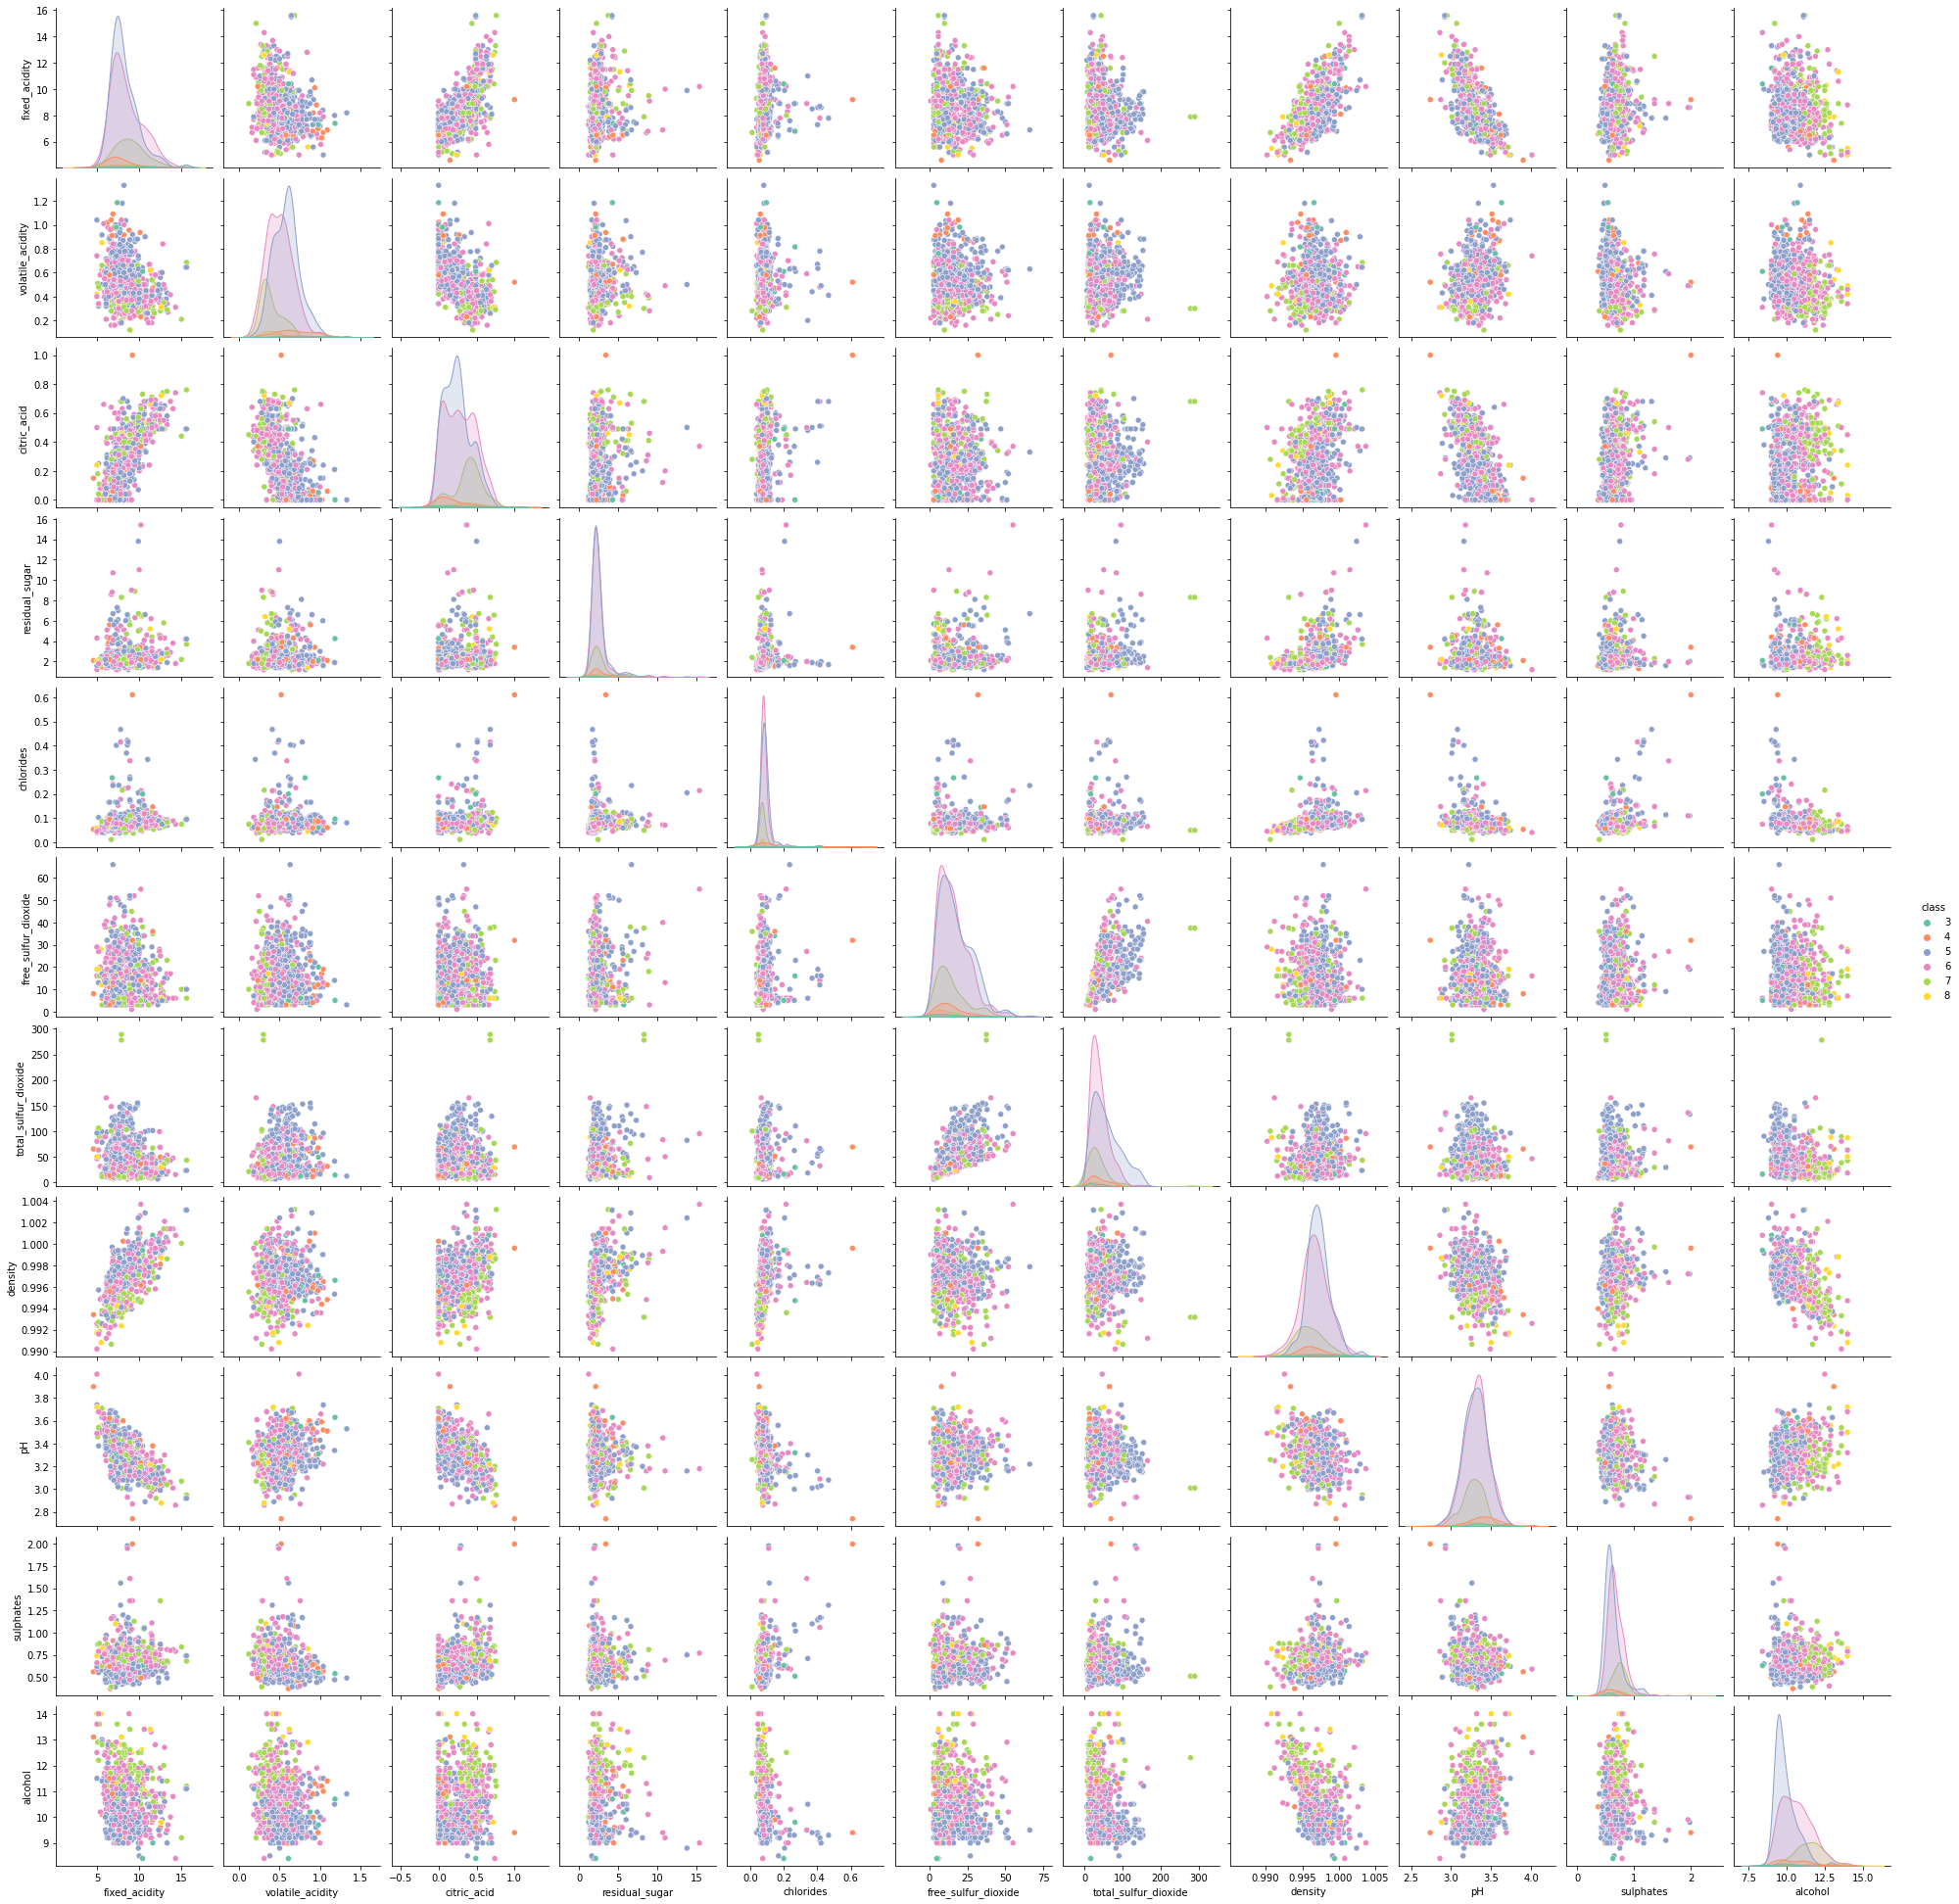

In [ ]:
sns.pairplot(train_data, palette="Set2", hue="class")

<font size=3.5>• The heatmap below show citric_acid and fixed_acidity, fixed_acidity and density are high correlation.\
• The class and alcohal are the higest correlation, 0.49.

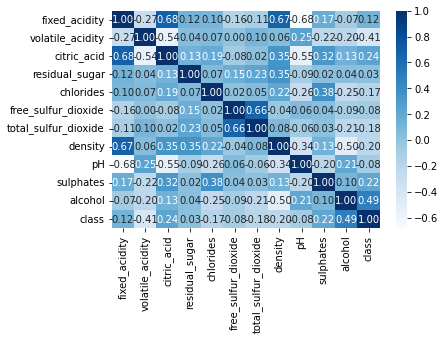

In [ ]:
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap="Blues")

<font size=5>9. Fill train_data missing value with group_mean, test_data with column_mean

In [ ]:
train_data = train_data.groupby("class").transform(lambda x: x.fillna(x.mean()))
train_data = pd.concat([train_data, y_train], axis=1)
train_data.isnull().sum()/len(train_data)

train_x_test = train_x_test.fillna(train_x_test.mean())

train_data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,8.382826,0.525746,0.274754,2.510967,0.087345,15.980569,45.979667,0.996786,3.308192,0.663859,10.431636,5.641260
std,1.723744,0.174476,0.188363,1.248574,0.043408,9.860147,32.669616,0.001860,0.149091,0.168076,1.027885,0.820865
min,4.600000,0.120000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990200,2.740000,0.370000,8.400000,3.000000
25%,7.200000,0.390000,0.110000,1.900000,0.071000,8.000000,22.000000,0.995715,3.210000,0.560000,9.600000,5.000000
50%,8.100000,0.520000,0.260000,2.200000,0.080000,14.189655,38.000000,0.996800,3.310000,0.630000,10.200000,6.000000
75%,9.200000,0.630000,0.420000,2.600000,0.092000,21.000000,59.000000,0.997800,3.390000,0.739439,11.000000,6.000000
max,15.600000,1.330000,1.000000,15.400000,0.610000,66.000000,289.000000,1.003690,4.010000,2.000000,14.000000,8.000000


<font size=5>10. The outliers\
<font size=3.5>• The residual_sugar and chlorides have the most outlier.

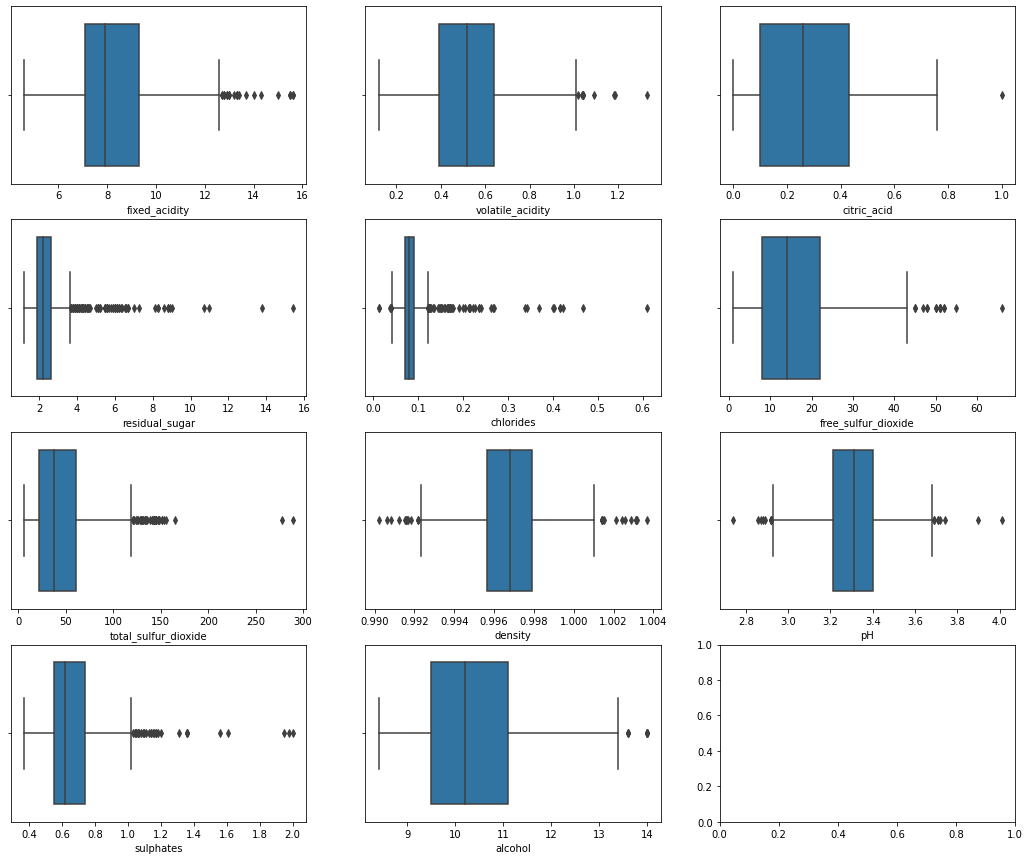

In [ ]:
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
for ind, col in zip(axs.flatten()[:-1], X_train.columns):
    sns.boxplot(ax=ind, x=X_train[col])

<font size=3.5>• remove the outliers

In [ ]:
for col in train_data.columns:
  if col == 'class':
    continue
  n_std = 1.5
  mean = train_data[col].mean()
  sd = train_data[col].std()

  df = train_data[(train_data[col] <= mean+(n_std*sd)) & (train_data[col] > mean-(n_std*sd))]

train_data = df
train_data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
mean,8.412278,0.533948,0.268067,2.470726,0.088652,16.188683,46.678391,0.996977,3.304501,0.660409,10.231729,5.561384
std,1.695165,0.175306,0.184754,1.177155,0.044163,9.895465,32.237556,0.001662,0.142857,0.170819,0.781540,0.768532
min,5.000000,0.120000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990640,2.740000,0.370000,9.000000,3.000000
25%,7.200000,0.400000,0.110000,1.900000,0.073000,8.000000,23.000000,0.995900,3.210000,0.550000,9.500000,5.000000
50%,8.100000,0.530000,0.250000,2.200000,0.081000,15.000000,38.963158,0.996890,3.302940,0.625064,10.016667,6.000000
75%,9.200000,0.640000,0.400000,2.600000,0.093000,22.000000,60.000000,0.997880,3.390000,0.730000,10.825000,6.000000
max,15.600000,1.330000,1.000000,15.400000,0.610000,66.000000,289.000000,1.003690,3.740000,2.000000,11.900000,8.000000


In [ ]:
train_data.to_csv('./gdrive/MyDrive/Dataset1/processed_train_dataset1.csv')
train_x_test.to_csv('./gdrive/MyDrive/Dataset1/processed_test_dataset1.csv')

#<font size=8>Dataset2
<font size=5>1. Read the data \
<font size=3.5>• dataset2 : phrase_train, phrase_test data, sentimental_train data

In [ ]:
#Put the Test data
df_phrase_test = read_file('./gdrive/MyDrive/Dataset2/X_test_2.csv')

#Put the Train x_data and y_data
df_phrase_train = read_file('./gdrive/MyDrive/Dataset2/X_train_2.csv')
df_sentimental_train = read_file('./gdrive/MyDrive/Dataset2/y_train_2.csv')

len_train, len_test = df_phrase_train.shape[0], df_phrase_test.shape[0]
X, y = pd.concat([df_phrase_train['Phrase'], df_phrase_test['Phrase']], axis=0), df_sentimental_train['Sentiment']

<font size=5>2. Data exploration\
<font size=3.5>• overview

In [ ]:
print('------------------------Dataset2----------------------')
print(df_phrase_train.describe())
print(df_phrase_test.describe())
print(df_sentimental_train.describe())

------------------------Dataset2----------------------
                            Phrase
count                       124848
unique                      124848
top     going to a house party and
freq                             1
                                                   Phrase
count                                               31211
unique                                              31211
top     finds a way to make J.K. Rowling 's marvelous ...
freq                                                    1
           Sentiment
count  124848.000000
mean        2.063581
std         0.893844
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000


<font size=5>3. The distribution of 5 classes with different length \
<font size=3.5>• the positive contain the most different phrase length \
<font size=3.5>• the neutral contain the most intensive phrase length

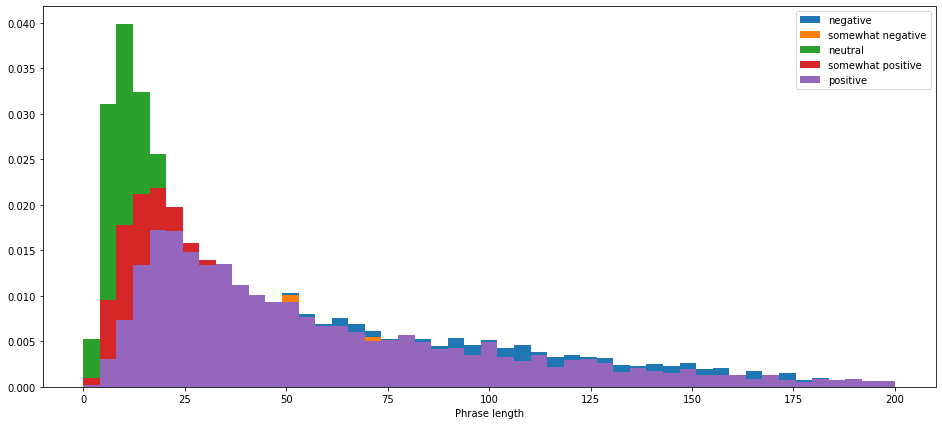

In [ ]:
#Distribution of length of each class
df_phrase_train['PhraseLength']=df_phrase_train['Phrase'].apply(lambda x: len(x))
df_phrase_train.sort_values(by='PhraseLength', ascending=False).head()

plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(df_phrase_train[df_sentimental_train['Sentiment']==0]['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(df_phrase_train[df_sentimental_train['Sentiment']==1]['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(df_phrase_train[df_sentimental_train['Sentiment']==2]['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(df_phrase_train[df_sentimental_train['Sentiment']==3]['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(df_phrase_train[df_sentimental_train['Sentiment']==4]['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

<font size=5>4. The distribution of class\
<font size=3.5>• class 2 is the largest amount follow by class 3

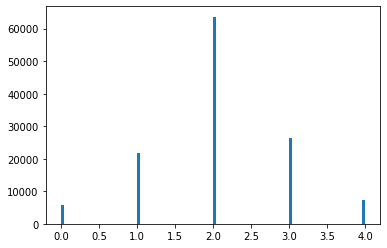

In [ ]:
plt.hist(y, bins=100)
plt.show()

<font size=5>5. Preprocess the data\
<font size=3.5>• Remove HTML tags using BeautifulSoup\
   • Keep only alphabetic characters using a regular expression\
   • Tokenize the text into individual words\
   • Remove stopwords (NLTK library)\
   • Perform lemmatization on the words (NLTK library)


In [ ]:
train_x_text = preprocess_data(X)

100%|██████████| 156059/156059 [01:42<00:00, 1529.94it/s]


<font size=3.5>• Use TF-IDF(term frequency–inverse document frequency) to give each words a score that is important to the document\
.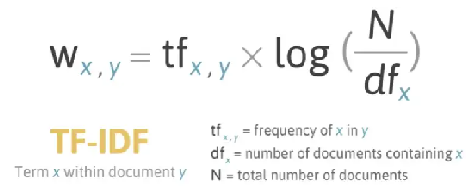\
(picture:https://medium.com/%E6%B7%B1%E6%80%9D%E5%BF%83%E6%80%9D/ml-%E7%94%A8%E5%9C%A8nlp-%E7%9A%84-tf-idf-51dac088a79)

In [ ]:
#Select top 1000 features in Tfidf, since the scarcely occur word will be eliminated
TF = TfidfVectorizer(max_features=1000)
TF_data = TF.fit_transform(train_x_text)

#Split the concate_data into original train and test
TF_train, TF_test = TF_data[:len_train], TF_data[len_train:]

#<font size=8>Node and Decision tree

In [ ]:
class Node:
    '''
        The information of node
        1. The location of feature
        2. The threshold to partition
        3. if reach leaf_node then return value
    '''
    def __init__(self, feat_loc=None, threshold=None, left=None, right=None, value=None, depth=None):
        self.feat_loc = feat_loc
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth

    def leaf(self):
        if self.value is not None:
            return self.value

class Decision_Tree:

    def __init__(self, max_depth=None, min_samples=None, feat=None, n_job=-1, random_n_feat=10, select_function="entropy"):  #傳入的Data設定DT的邊界條件
        '''
            The hyperparameter of DT
            1. max_depth of the tree
            2. min_sample of each node
            3. numbers of features
            4. n_job of the cores of paralleling select best_feature and best_threshold
            5. random_n_feat of the original features of Data
            5. select_function is the criterion to calculate Parent and Child node
        '''
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feat = feat
        self.n_job = n_job
        self.random_n_feat = random_n_feat
        self.tree = None
        self.evaluation = None

        if select_function == 'entropy':
            self.evaluation = self.entropy
        if select_function == 'Gini':
            self.evaluation = self.Gini

    #Entropy
    def entropy(self, y):
        y = y.flatten()
        unique, counts = np.unique(y, return_counts=True)
        if len(unique) == 0:
            return 0
        total = np.sum(counts)
        return -np.sum(np.log2(counts/total))
        # return -np.sum([((j/total)*np.log2(j/total)) for j in counts if j > 0])

    #Gini
    def Gini(self, y):
        y = y.flatten()
        unique, counts = np.unique(y, return_counts=True)
        total = np.sum(counts)
        return 1 - np.sum([(i/total) for i in counts])

    def fit(self, X, y):
        #Random select the number of feature to be selected
        n_features = self.feat

        self.tree = self._grow_tree(X, y, n_features)

    def predict(self, test_x):
        all_prediction = []

        #Iteratively get each instance in test_x
        for i in test_x:

            #Because the data type I use include sparse metrix and ndarray.
            if isinstance(i, np.ndarray):
              x = i.flatten()
            else:
              x = i.toarray().flatten()

            prediction = self._classify(x, self.tree)
            all_prediction.append(prediction)

        return np.array(all_prediction)

    def _classify(self, each_test_data, node):

        #Stopping Criterion, if the test instance reach the leaf_node
        if node.leaf() is not None:
            return node.value

        #If the test instance is smaller than node threshold, go to left, vice versa.
        if each_test_data[node.feat_loc] <= node.threshold:
            return self._classify(each_test_data, node.left)

        return self._classify(each_test_data, node.right)

    def _grow_tree(self, x, y, n_features, depth = 0):

        #Stopping Criterion
        unique, counts = np.unique(y, return_counts=True)
        if (len(y) <= self.min_samples) or (depth > self.max_depth) or (len(counts) == 1):
          leaf_value = self._leaf_value(y)
          return Node(value=leaf_value, depth=depth)

        #Find the best feature and threshold based on largest information gain
        selected_feature, selected_threshold = self._selected_feature_threshold(x, y, n_features)

        #Split the data based on the best feature and threshold I find
        right, left = self._split(x, selected_feature, selected_threshold)

        #Somtimes, there's the probability that the partition cause to empty node
        if right.shape[0] == 0 or left.shape[0] == 0:
          leaf_value = self._leaf_value(y)
          return Node(value=leaf_value, depth=depth)

        left_x, left_y = x[left, :], y[left]
        right_x, right_y = x[right, :], y[right]

        #After classify the instance, go to the lower node
        l = self._grow_tree(left_x, left_y, n_features, depth + 1)
        r = self._grow_tree(right_x, right_y, n_features, depth + 1)

        return Node(selected_feature, selected_threshold, l, r, depth=depth)

    def _leaf_value(self, y):

        #Calculate the value of the node, based on the most frequency value
        y = y.flatten()
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def _split(self, x, column, split_point):

        #Split the instances, set the split_point as threshold to separate.
        left = np.argwhere(x[:, column] <= split_point)
        right = np.argwhere(x[:, column] > split_point)

        return right[:, 0], left[:, 0]

    def _selected_feature_threshold(self, x, y, n_features):
        target = y

        #Random select feature in each node
        n_features = random.sample(n_features, self.random_n_feat)

        #Compute the largest IG(information gain) among all instances in each column of feature
        def compute_ig(column, target):
          best_IG, best_feature, best_split_point = 0, -1, -1

          if isinstance(x[:, column], np.ndarray):
            nonzero_rows = np.unique(x[:, column]).flatten()
            min_value = np.mean(x[:, column])
          else:
            nonzero_rows = np.unique(x[:, column].toarray()).flatten()
            min_value = 0


          for split_point in nonzero_rows:
            if split_point == min_value or split_point == 0:
              continue

            #Use the target which is before splitting
            parent_entropy = self.evaluation(target)

            #Use the x_data and the selected split_point and selected feature to split
            right_id, left_id = self._split(x, column, split_point)
            left, right = y[left_id], y[right_id]
            IG = self._information_gain(parent_entropy, left, right)

            #if the IG in the selected threshold higher than previous largest one,
            #Change 1.best_IG, 2.best_feature, 3.best_split_point
            if abs(IG) > best_IG:
              best_IG = abs(IG)
              best_feature = column
              best_split_point = split_point

          return best_IG, best_feature, best_split_point

        #The result save all best IG, feature, threshold among all  features.
        #Use the n_jobs CPU_CORES to accelerate the code
        result = Parallel(n_jobs=self.n_job, verbose=20)(delayed(compute_ig)(column, target=target) for column in n_features)

        #Select the best IG, feature, threshold in best feature, according to IG
        max_IG_id = np.argmax(result, axis=0)
        best_feature, best_split_point = result[max_IG_id[0]][1], result[max_IG_id[0]][2]

        return best_feature, best_split_point

    def _information_gain(self, parent_entropy, left, right):
        #Information of Parent minus Information of Child
        portion_l = len(left)/(len(left) + len(right))
        portion_r = len(right)/(len(left) + len(right))

        #Evalution depends on the user's input.
        child_entropy = portion_l*self.evaluation(left) + portion_r*self.evaluation(right)
        IG = parent_entropy - child_entropy
        return IG

#<font size=8>Training
<font size=5>Parameter: \
<font size=4>1. min_samples = 10 \
<font size=4>2. max_depth  = 10

<font size=5>Split the data into train and test

In [ ]:
#Split the train into train_x and train_y(target)
train = train_data.to_numpy()
x_train, y_train = train[:, :11], train[:, -1]

#Prepare X_test_1
X_test_1 = train_x_test.to_numpy()

#Split the train_x and train_y into train_x, test_x, train_y, test_y, stratify according to train_y, because of imbalanced class
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
#Prepare X_test_2
X_test_2 = TF_test

#Split the TF_train into train and test
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(TF_train, y, test_size=0.2, stratify=y)
y_train_2, y_val_2 = y_train_2.to_numpy(), y_val_2.to_numpy()

<font size=5>Dataset1

In [ ]:
#Use entropy criteria
DT_entropy_1 = Decision_Tree(max_depth=10, min_samples=10, random_n_feat=11, feat=range(X_train_1.shape[1]), select_function='entropy')
DT_entropy_1.fit(X_train_1, y_train_1)

#Use Gini criteria
DT_Gini_1 = Decision_Tree(max_depth=10, min_samples=10, random_n_feat=11, feat=range(X_train_1.shape[1]), select_function='Gini')
DT_Gini_1.fit(X_train_1, y_train_1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0437

<font size=5>Dataset2

In [ ]:
#Use entropy criteria
DT_entropy_2 = Decision_Tree(max_depth=10, min_samples=10, random_n_feat=100, feat=range(X_train_2.shape[1]), select_function='entropy')
DT_entropy_2.fit(X_train_2, y_train_2)

#Use Gini criteria
DT_Gini_2 = Decision_Tree(max_depth=10, min_samples=10, random_n_feat=100, feat=range(X_train_2.shape[1]), select_function='Gini')
DT_Gini_2.fit(X_train_2, y_train_2)

串流輸出內容已截斷至最後 5000 行。
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0210s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0839s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1185s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | ela

#<font size=8>Evaluation
<font size=4>. Method (confusion metrix, f1-score, recall)

<font size=5>Dataset1 :

<font size=4>1.Compare two criterion (entropy, Gini)

In [ ]:
Prediction_entropy_1 = DT_entropy_1.predict(X_val_1)
Prediction_Gini_1 = DT_Gini_1.predict(X_val_1)

print('--------------------------Entropy Dataset1-----------------------')
report(Prediction_entropy_1, y_val_1)
print(Prediction_entropy_1)
print('----------------------------Gini Dataset1-----------------------')
report(Prediction_Gini_1, y_val_1)
print(Prediction_Gini_1)

--------------------------Entropy Dataset1-----------------------
Accuracy: 0.4888888888888889
Confusion Matrix:
[[ 0  0  1  0  0  0]
 [ 0  0  5  2  0  0]
 [ 0  4 45 29  3  0]
 [ 0  0 30 37  6  0]
 [ 0  0  4  8  5  0]
 [ 0  0  0  0  0  1]]
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         7
         5.0       0.53      0.56      0.54        81
         6.0       0.49      0.51      0.50        73
         7.0       0.36      0.29      0.32        17
         8.0       1.00      1.00      1.00         1

    accuracy                           0.49       180
   macro avg       0.40      0.39      0.39       180
weighted avg       0.47      0.49      0.48       180

[5. 6. 4. 5. 6. 6. 5. 6. 5. 7. 6. 6. 5. 5. 6. 6. 5. 5. 6. 7. 6. 6. 5. 5.
 6. 5. 6. 5. 5. 5. 7. 6. 5. 5. 6. 5. 5. 7. 6. 7. 5. 5. 6. 6. 5. 6. 6. 7.
 7. 6. 6. 5. 7. 5. 6. 5. 6. 5. 6. 6. 4. 5. 7. 6.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [ ]:
x = Prediction_entropy_1
pd.DataFrame(x).to_csv('./gdrive/MyDrive/Dataset1/dataset1_prediction.csv')


<font size=4>2. Test Dataset1

In [ ]:
Prediction_entropy_test = DT_entropy_1.predict(X_test_1)
print('--------------------------Entropy Dataset1 Test-----------------------')
# report(Prediction_entrop_test, 'Test target')
print(Prediction_entropy_test)

Prediction_Gini_test = DT_Gini_1.predict(X_test_1)
print('----------------------------Gini Dataset1 Test-----------------------')
# report(Prediction_Gini_test, 'Test target')
print(Prediction_Gini_test)

--------------------------Entropy Dataset1 Test-----------------------
[5. 6. 5. 5. 6. 5. 6. 5. 5. 6. 6. 6. 5. 5. 6. 6. 5. 5. 6. 6. 7. 5. 5. 4.
 6. 6. 5. 6. 6. 5. 5. 6. 6. 6. 5. 5. 6. 6. 6. 5. 6. 6. 6. 4. 5. 6. 5. 6.
 7. 6. 5. 5. 6. 5. 7. 5. 6. 5. 5. 7. 6. 5. 6. 6. 5. 5. 5. 6. 6. 6. 6. 5.
 5. 7. 6. 5. 7. 7. 7. 5. 7. 7. 6. 5. 5. 6. 6. 6. 6. 6. 5. 5. 7. 5. 5. 5.
 5. 5. 8. 6. 6. 6. 6. 5. 6. 6. 6. 6. 6. 5. 6. 5. 7. 6. 6. 6. 7. 7. 6. 6.
 5. 5. 5. 7. 6. 6. 5. 5. 6. 6. 6. 5. 6. 6. 6. 6. 6. 7. 6. 5. 5. 6. 6. 6.
 5. 5. 7. 6. 7. 6. 6. 6. 7. 7. 5. 5. 5. 6. 7. 5. 5. 6. 6. 6. 6. 5. 6. 6.
 5. 7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6. 7. 5. 6. 6. 5. 7. 5. 6.
 6. 7. 6. 5. 6. 7. 6. 5. 5. 6. 6. 6. 5. 6. 5. 6. 6. 6. 6. 5. 5. 5. 6. 6.
 6. 6. 6. 5. 6. 6. 6. 5. 6. 6. 7. 7. 5. 6. 6. 7. 6. 5. 6. 7. 6. 5. 5. 6.
 5. 5. 5. 5. 6. 6. 7. 6. 7. 6. 5. 5. 5. 6. 5.]
----------------------------Gini Dataset1 Test-----------------------
[5. 5. 5. 5. 6. 5. 5. 5. 5. 6. 5. 5. 5. 5. 6. 6. 5. 6. 6. 5. 7. 5. 5. 6.
 5. 5. 5.

<font size=5>Dataset2 :

<font size=4>1.Compare two criterion (entropy, Gini)

In [ ]:
Prediction_entropy_2 = DT_entropy_2.predict(X_val_2)
Prediction_Gini_2 = DT_Gini_2.predict(X_val_2)

print('--------------------------Entropy Dataset2 Validation-----------------------')
report(Prediction_entropy_2, y_val_2)
print(Prediction_entropy_2
      )
print('----------------------------Gini Dataset2 Validation-----------------------')
report(Prediction_Gini_2, y_val_2)
print(Prediction_Gini_2)

--------------------------Entropy Dataset2 Validation-----------------------
Accuracy: 0.5175410492591109
Confusion Matrix:
[[    9    29  1066    24     4]
 [    9    31  4227    93     4]
 [    2    18 12550   160     3]
 [    1     8  4954   289    16]
 [    0     1  1245   183    44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.01      0.02      1132
           1       0.36      0.01      0.01      4364
           2       0.52      0.99      0.68     12733
           3       0.39      0.05      0.10      5268
           4       0.62      0.03      0.06      1473

    accuracy                           0.52     24970
   macro avg       0.46      0.22      0.17     24970
weighted avg       0.47      0.52      0.37     24970

[2 2 3 ... 2 2 2]
----------------------------Gini Dataset2 Validation-----------------------
Accuracy: 0.5113336003203844
Confusion Matrix:
[[    3    20  1109     0     0]
 [    5    70  4287     

<font size=4>2. Test Dataset2

In [ ]:
Prediction_entropy_test_2 = DT_entropy_2.predict(X_test_2)
print('--------------------------Entropy Dataset2 Test-----------------------')
# report(Prediction_entrop_test_2, 'Test target')
print(Prediction_entropy_test_2)

Prediction_Gini_test_2 = DT_Gini_2.predict(X_test_2)
print('----------------------------Gini Dataset2 Test-----------------------')
# report(Prediction_Gini_test_2, 'Test target')
print(Prediction_Gini_test_2)

--------------------------Entropy Dataset2 Test-----------------------
[2 2 2 ... 2 2 2]
----------------------------Gini Dataset2 Test-----------------------
[2 2 2 ... 2 2 2]
